[intro]

In [72]:
import subprocess
import pandas as pd
import itables
import os
import json
from ipywidgets import Dropdown

import glob
from IPython.core.display import Image, display

#get top directory path of the current git repository, under the presumption that 
#the notebook was launched from within the repo directory
gitRepoPath=subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('ascii').strip()

#move to the top of the directory
os.chdir(gitRepoPath)

#load the WMADB JSON
with open(os.path.join('dbStore','WMAnatDB.json')) as json_data:
    WMAnatDB = json.load(json_data)
    
#build components of pandas spreadsheet
import pandas as pd
curators=[WMAnatDB[x]['curator']['1'] for x in WMAnatDB.keys()]
titles=[WMAnatDB[x]['title'][0] for x in WMAnatDB.keys()]
tractNums=[len(WMAnatDB[x]['tractDepictions']) for x in WMAnatDB.keys()]
years=[WMAnatDB[x]['published']['date-parts'][0][0] for x in WMAnatDB.keys()]
authors=[WMAnatDB[x]['author'][0]['given'] + ' ' + WMAnatDB[x]['author'][0]['family'] for x in WMAnatDB.keys()]

#make the spreadsheet
dataStructure={'title': titles, 'firstAuthor': authors, 'year': years, 'numOfTracts': tractNums, 'curator': curators}
overviewFrame=pd.DataFrame(data=dataStructure)

#use itables to make it nice and interactive
import qgrid
qgrid_widget= qgrid.show_grid(overviewFrame,show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

now that we have 

In [77]:
def unpackEntry(dfEntry):
    #this function unpacks entries in the dataframe for clarity and conciseness
    if type(dfEntry)==dict:
        #for the columns we have specified, we do not care about the keys used, they are just placeholders
        dfEntry=list(dfEntry.values())
    if type(dfEntry)==list and len(dfEntry)>1:
        #if it's a list of multiple items, concat them
        dfEntry=' '.join(dfEntry)
    if type(dfEntry)==list and len(dfEntry)==1:
        #if it's a list of length 1, just unpack it
        dfEntry=dfEntry[0]
        #if it's just a string, we probably want it left the way it is
    return dfEntry

def unpackArticleJSONtoPdDF(articleJSONDict):
    #this function unpacks an article such that there are n rows (with duplicated information)
    #in the output dataframe, where n is the number of tracts in the tractDepictions record
    #unpack heighest tier of json dictionary
    dfBaseRow=pd.json_normalize(articleJSONDict,max_level=0)
    #unpack the entries for each tract
    expandedDepictions=pd.json_normalize(dfBaseRow['tractDepictions'],max_level=0)
    #for each tract, expand to terms used, descriptions and figures
    expandedTractDF=[pd.json_normalize(iEntries, max_level=0) for iEntries in expandedDepictions.values.tolist()]
    
    #create a replicated row dataframe to merge these tract entries on to
    toMergeDF=pd.concat([dfBaseRow]*len(expandedDepictions.columns), ignore_index=True)
    #concat them together
    outDF=pd.concat([toMergeDF,expandedTractDF[0]],axis=1)
    #drop the tractDepictions entry as we no longer need this
    outDF=outDF.drop('tractDepictions',axis=1)
    
    #finally, convert the dictionaries in the relevant columns into lists
    #these are the columns we wish to convert
    columnsToConvert=['curator','doi','species','methods','published','title','container-title','tractTermsUsed']
    for iColumnsToConvert in columnsToConvert:   
        outDF[iColumnsToConvert]=outDF[iColumnsToConvert].map(lambda x: unpackEntry(x) ) 
    #convert descriptions and figures to lists
    outDF['descriptions']=outDF['descriptions'].map(lambda x: list(x.values()))
    outDF['figures']=outDF['figures'].map(lambda x: list(x.values()))
    return outDF

#extract the article dictionary JSONs to a list
articleListObjects=[WMAnatDB[x] for x in WMAnatDB.keys()]
#perform the tract expansion on them
unpackedArticleDFs=[unpackArticleJSONtoPdDF(iArticles) for iArticles in articleListObjects]
#merge them in to one dataframe
wholeDBDF=pd.concat(unpackedArticleDFs,axis=0,ignore_index=True)
#just index the year for date
wholeDBDF['published']=wholeDBDF['published'].map(lambda x: x[0][0] )
#import qgrid and use it to view the DB
import qgrid
#show the informative columns
qgrid_widget= qgrid.show_grid(wholeDBDF[['curator','title','species','methods','tractTermsUsed','published']],show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [84]:
descriptionTable=wholeDBDF.loc[qgrid_widget.get_changed_df().index,['title','descriptions']].explode('descriptions')

from pyWMAD import scrape
descriptionTable['descriptions']=descriptionTable['descriptions'].map(lambda x: scrape.extractGoogleHighlightLinkText(x))


ValueError: Regex search for failed to return match; possible redirect issue

In [99]:
from PIL import Image
import requests


figuresTable=wholeDBDF.loc[qgrid_widget.get_changed_df().index,['title','figures']].explode('figures')

def plotFigure(index):
    imgOut = Image.open(requests.get(figuresTable['figures'].to_list()[index], stream=True).raw)
    display(imgOut)
#from ipywidgets import IntSlider
#from ipywidgets import interact, interactive, fixed, interact_manual
#figureSlider=IntSlider( value=1, min=1, max= len(figuresTable) step=1, description='Figure Index', continuous_update=False)


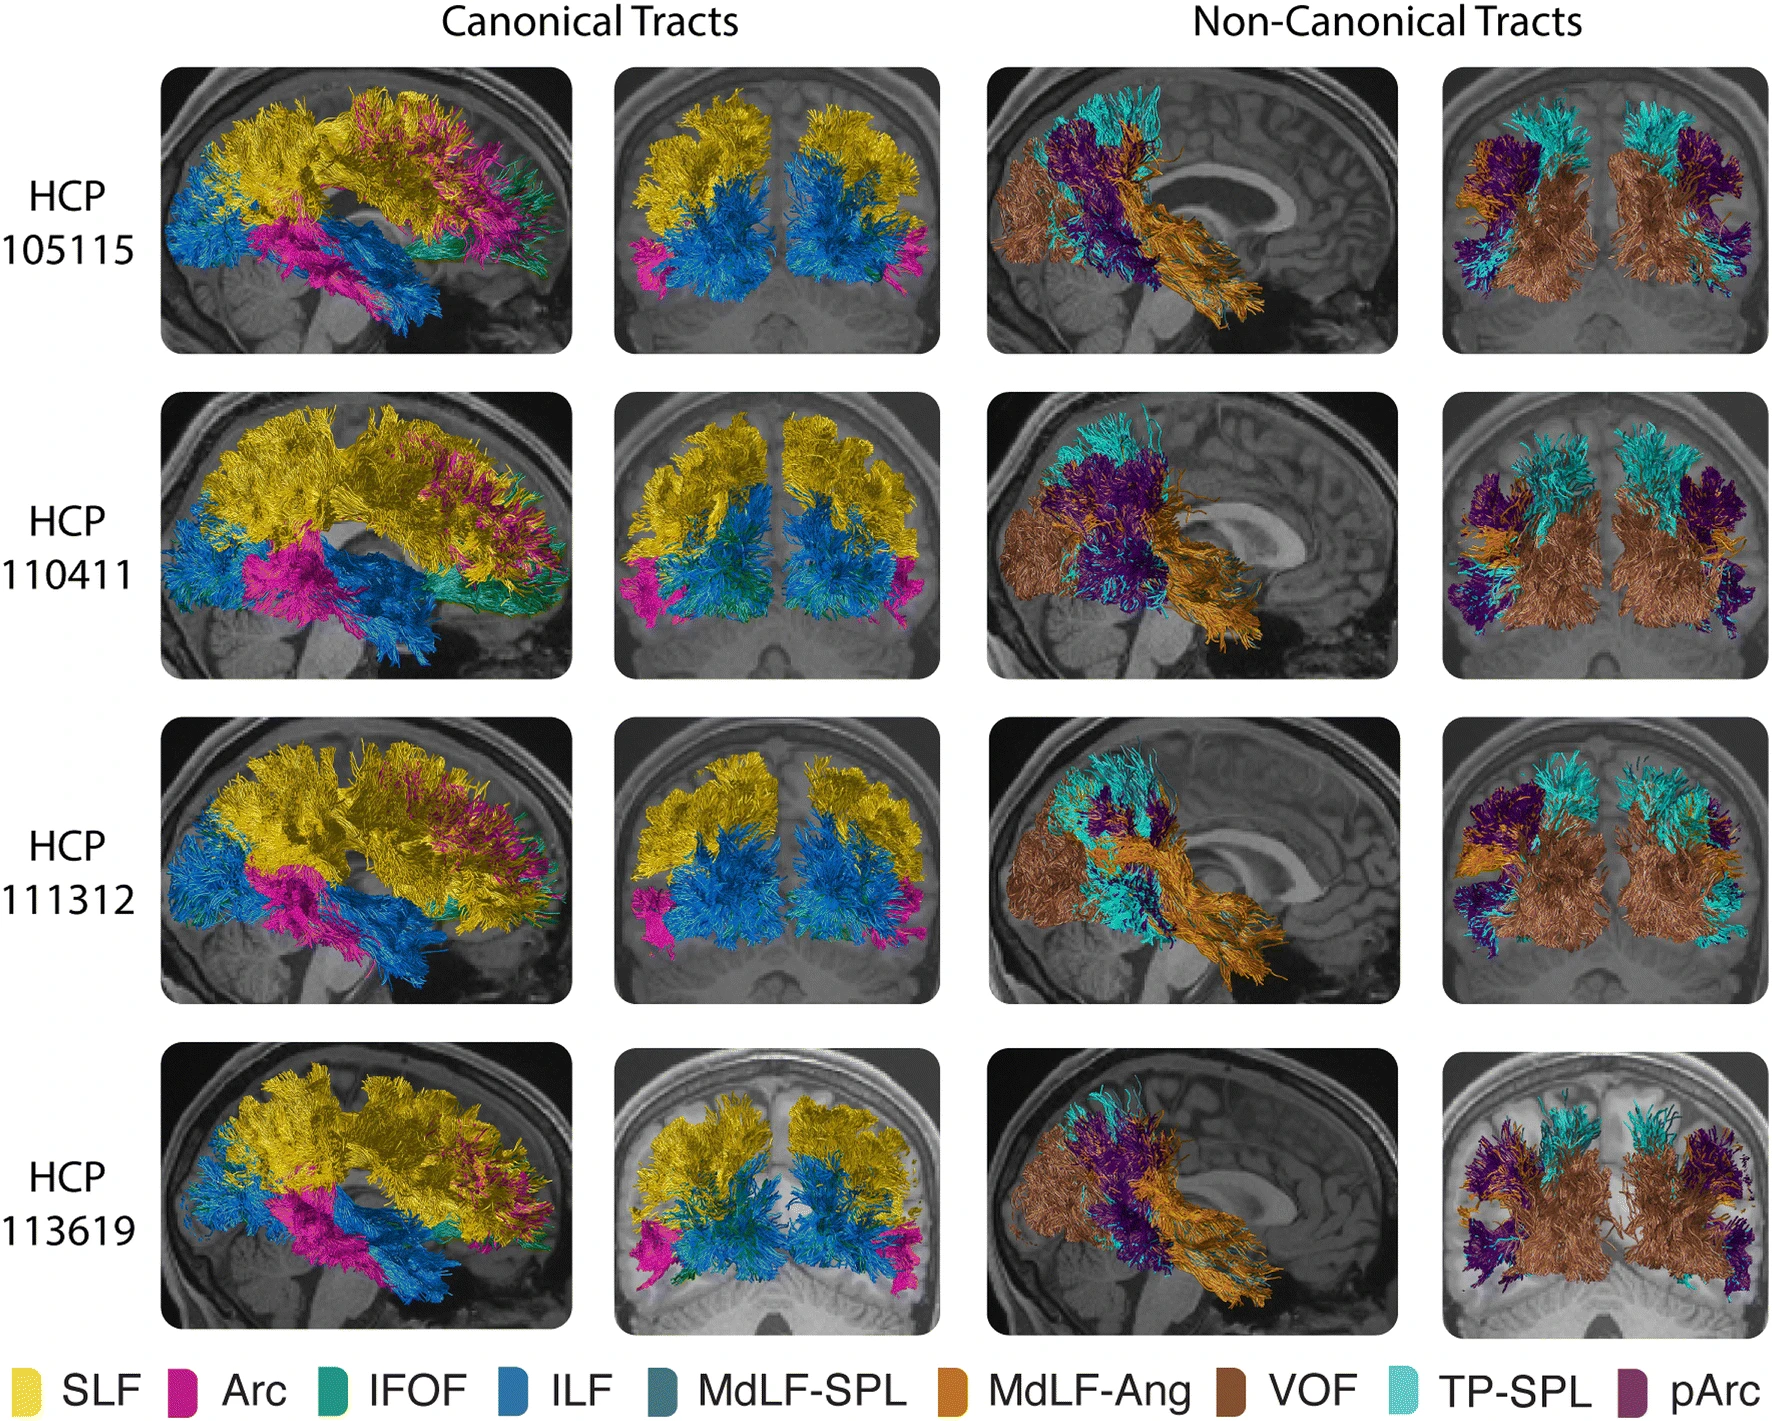

In [100]:
plotFigure(1)

In [74]:
wholeDBDF['descriptions']=wholeDBDF['descriptions'].map(lambda x: list(x.values()))

In [76]:
wholeDBDF['descriptions'][1]

['https://www.frontiersin.org/articles/10.3389/fnana.2016.00040/full#:~:text=The%20overall%20fiber%20architecture%20in%20all%20regions%20of%20interest%20were%20preserved%20(Figures%206B%E2%80%93D%2C%207C%2CD)%20by%20pliODFs.%20This%20holds%20true%20for%20deep%20white%20matter%20tracts%20(e.g.%2C%20in%20the%20stratum%20sagittale%2C%20Figure%206D%2C%20or%20the%20corpus%20callosum%2C%20Figure%207D).',
 'https://www.frontiersin.org/articles/10.3389/fnana.2016.00040/full#:~:text=Figure%207.%20Coronal,along%20the%20CC.']